### Neural Network with Sigmoid for Regression

Three-layer neural network for regression tasks using Sigmoid activation function

In [660]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork():
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
        self.inputLayerSize = inputLayerSize 
        self.hiddenLayerSize = hiddenLayerSize 
        self.outputLayerSize = outputLayerSize 
        
        # Initialize Weights
        self.Wh = np.random.randn(inputLayerSize, hiddenLayerSize)/np.sqrt(inputLayerSize)
        self.Wo = np.random.randn(hiddenLayerSize, outputLayerSize)/np.sqrt(hiddenLayerSize)
        print  ("Weights: ",self.Wh,self.Wo)
        
        # Initialize Biases
        # Initial small positive value to avoid Relu units dying
        self.Bh = np.full((1, hiddenLayerSize), 0.2)
        self.Bo = np.full((1, outputLayerSize), 0.2)
        print ("Biases: ",self.Bh,self.Bo)
        
        # Normalized Data Range
        self.minNorm = 0
        self.maxNorm = 1
        
        # Weighted Inputs
        self.Zh = None
        self.Zo = None
        
        # Activations
        self.Ah = None
        self.Ao = None
        
        # Logging
        self.log_interval = 1000
        
    def normalize(self, X, newMin, newMax):
        curMin = np.amin(X, axis=0)
        curMax = np.amax(X, axis=0)
        curRange = (curMax - curMin)  
        newRange = (newMax - newMin)
        return (((X - curMin) * newRange) / curRange) + newMin

    def denormalize(self, normalized, oldMin, oldMax):
        return self.normalize(normalized, oldMin, oldMax)

    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_grad(self,z):
        #dr/dz = 1(z>0)
        grad = np.copy(z)
        grad[z <= 0] = 0
        grad[z > 0] = 1
        return grad
    
    def cost(self, X, y):
        output = self.feed_forward(X)
        cost = np.sum((output-y)**2) / 2.0
        return cost
    
    def cost_grad(self, output, y):
        return output - y
    
    def dCdW(self, layer_input, layer_error):
        #Derivative of Cost with respect to any weight in the network
        return np.dot(layer_input.T, layer_error)
            
    def dCdB(self, curLayerError):
        #Derivative of Cost with respect to the Bias of any neuron in the network
        '''
        CurLayerError has one row for each observation in our training set.
        This is fine for dCdW because the matrix multiplication takes
        care of transforming the output into dimensions that
        equal our weight dimensions (so we can subtract).
        However bias isn't multiplied by anything so we're stuck with 
        the dimensions of the output error. To fix this take the sum of
        all the output errors across observations (we could also take the average
        but our learning rate will handle scaling this value appropriately).
        The operation below sums all the values in a matrix on the row axis (0).
        It's essentially like summing all the rows into a single row. The column
        dimensions remain unchanged.
        '''
        return np.sum(curLayerError, axis=0, keepdims=True)
    
    def feed_forward(self, X):
        self.Zh = np.dot(X, self.Wh) + self.Bh
        self.Ah = self.relu(self.Zh)
        self.Zo = np.dot(self.Ah, self.Wo) + self.Bo
        self.Ao = self.relu(self.Zo) #network output
        return self.Ao
    
    def backprop(self, X, output, y):
        err_output = self.cost_grad(output, y) * self.relu_grad(self.Zo)
        err_hidden = np.dot(err_output, self.Wo.T) * self.relu_grad(self.Zh)

        # Weight Gradients
        dCdWh = self.dCdW(X, err_hidden)
        dCdWo = self.dCdW(self.Ah, err_output)
        
        # Bias Gradients
        dCdBh = self.dCdB(err_hidden)
        dCdBo = self.dCdB(err_output)

        return dCdWh, dCdWo, dCdBh, dCdBo
    
    def update_weights(self, X, y, lr):
        output = self.feed_forward(X)
        dCdWh, dCdWo, dCdBh, dCdBo = self.backprop(X, output, y)
        
        # Update Weights
        self.Wh -= lr * dCdWh
        self.Wo -= lr * dCdWo
        
        # Update Biases
        self.Bh -= lr * dCdBh
        self.Bo -= lr * dCdBo
    
        cost = self.cost(X, y)
        return cost

    def train(self, X, y, epochs, lr, log_interval):
        self.log_interval=log_interval
        X = self.normalize(X, self.minNorm, self.maxNorm)
        y = self.normalize(y, self.minNorm, self.maxNorm)
        cost_history = []
        for epoch in range(1,epochs+1):
            self.log("Epoch %d ---------------" % epoch, epoch)
            cost = self.update_weights(X, y, lr)
            cost_history.append(cost)
            msg = "Cost:" + str(round(cost,5)) + "\n"
            self.log(msg, epoch)
#             self.log("Weights:" + str(self.Wh) + str(self.Wo), epoch)
#             self.log("Zh" + str(self.Zh), epoch)
#             self.log("Ah" + str(self.Ah), epoch)
#             self.log("Zo" + str(self.Zo), epoch)
#            self.log("Ao" + str(self.Ao), epoch)
        return cost_history
    
    def predict(self, X, y_min, y_max):
        normalized_input = self.normalize(X, self.minNorm, self.maxNorm)
        output = self.feed_forward(normalized_input)
        denormalized_output = self.denormalize(output, y_min, y_max)
        return denormalized_output
    
    def log(self, msg, epoch):
        if epoch == 1 or epoch % self.log_interval == 0:
            print(msg)        

### Visualize

In [661]:
def graph(x, y, xlabel="X", ylabel="Y", title="X vs Y"):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def graph_error(error_history):
    iterations = [i for i in range(1,len(error_history)+1)]
    plt.plot(iterations, error_history)
    plt.title('Error Rate')
    plt.xlabel('Training Iterations')
    plt.ylabel('Mean Squared Error')
    plt.show()

### Load Data

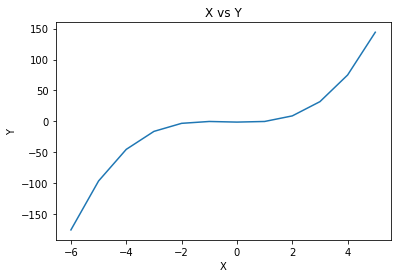

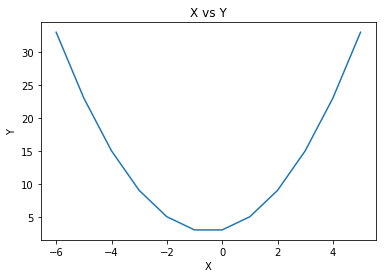

In [662]:
def quadratic(x):
    return x**2 + x + 3

def get_quadratic_data(start,end):
    X = np.array([i for i in range(start,end)], dtype="float64")    
    X.shape = (len(X),1)
    
    y = np.array([quadratic(X[i]) for i in range(len(X))], dtype="float64")
    y.shape = (len(y),1)
    
    return X, y

def cubic(x):
    return x**3 + x**2 - x - 1

def get_cubic_data(start,end):
    X = np.array([i for i in range(start,end)], dtype="float64")    
    X.shape = (len(X),1)
    
    y = np.array([cubic(X[i]) for i in range(len(X))], dtype="float64")
    y.shape = (len(y),1)
    
    return X, y

cX, cy = get_cubic_data(-6,6)
graph(cX,cy)

qX, qy = get_quadratic_data(-6,6)
graph(qX,qy)

### Training

In [663]:
np.random.seed(3)
X,y = get_quadratic_data(-20,21)
X,y = get_cubic_data(-20,21)
nn = NeuralNetwork(1,20,1)

Weights:  [[ 1.78862847  0.43650985  0.09649747 -1.8634927  -0.2773882  -0.35475898
  -0.08274148 -0.62700068 -0.04381817 -0.47721803 -1.31386475  0.88462238
   0.88131804  1.70957306  0.05003364 -0.40467741 -0.54535995 -1.54647732
   0.98236743 -1.10106763]] [[-0.26498446]
 [-0.04598472]
 [ 0.33231287]
 [ 0.05293137]
 [-0.22892532]
 [-0.15943013]
 [ 0.13980902]
 [-0.03589188]
 [-0.17191703]
 [-0.05143643]
 [ 0.16659965]
 [ 0.4418718 ]
 [-0.27819443]
 [-0.14007108]
 [-0.17972756]
 [-0.54092344]
 [-0.20656618]
 [-0.22894558]
 [ 0.25132911]
 [-0.02949692]]
Biases:  [[ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2]] [[ 0.2]]


Epoch 1 ---------------
Cost:4.92782

Epoch 1000 ---------------
Cost:0.11452

Epoch 2000 ---------------
Cost:0.10822

Epoch 3000 ---------------
Cost:0.10606

Epoch 4000 ---------------
Cost:0.10487

Epoch 5000 ---------------
Cost:0.10412

Epoch 6000 ---------------
Cost:0.10356

Epoch 7000 ---------------
Cost:0.10317

Epoch 8000 ---------------
Cost:0.1029

Epoch 9000 ---------------
Cost:0.10266

Epoch 10000 ---------------
Cost:0.10247

Epoch 11000 ---------------
Cost:0.10229

Epoch 12000 ---------------
Cost:0.10213

Epoch 13000 ---------------
Cost:0.10194

Epoch 14000 ---------------
Cost:0.10167

Epoch 15000 ---------------
Cost:0.10116

Epoch 16000 ---------------
Cost:0.09995

Epoch 17000 ---------------
Cost:0.09709

Epoch 18000 ---------------
Cost:0.09308

Epoch 19000 ---------------
Cost:0.08943

Epoch 20000 ---------------
Cost:0.0857



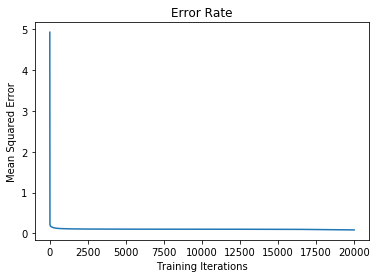

In [664]:
cost_hist = nn.train(X, y, epochs=20000, lr=.0001, log_interval=1000)
graph_error(cost_hist)

In [653]:
start,end = (-50,50)

#Quadratic
X,y = get_quadratic_data(start,end)
output = nn.predict(X,y_min=0,y_max=quadratic(max(abs(start), abs(end))))

#Cubic
#X,y = get_cubic_data(start, end)
#output = nn.predict(X,y_min=cubic(start), y_max=cubic(end))

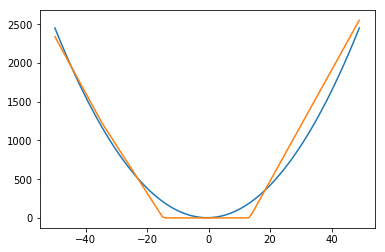

In [654]:
plt.plot(X,y)
plt.plot(X,output)
plt.show()

### Scikit-Learn Example

In [566]:
#https://scikit-neuralnetwork.readthedocs.io/en/latest/module_mlp.html#regressor
from sknn.mlp import Regressor
from sknn.mlp import Layer
hiddenLayer = Layer("Sigmoid", units=3)
outputLayer = Layer("Linear", units=1)
nn = Regressor([hiddenLayer, outputLayer],learning_rule='sgd',learning_rate=.01,
               batch_size=5,loss_type="mse",debug=False,verbose=False,regularize=None)

Initializing neural network with 2 layers, 1 inputs and 1 outputs.
  - Dense: Sigmoid    Units:  3   
  - Dense: Linear     Units:  1   

Training on dataset of 11 samples with 22 total size.
  - Early termination after 10 stable iterations.
    1          2.627e+02                 N/A            0.0s
    2          1.888e+02                 N/A            0.0s
    3          4.005e+02                 N/A            0.0s
    4          1.629e+02                 N/A            0.0s
    5          1.195e+02                 N/A            0.0s
    6          1.068e+02                 N/A            0.0s
    7          1.007e+02                 N/A            0.0s
    8          9.278e+01                 N/A            0.0s
    9          8.761e+01                 N/A            0.0s
   10          8.427e+01                 N/A            0.0s
   11          8.442e+01                 N/A            0.0s
   12          8.229e+01                 N/A            0.0s
   13          9.281e+01  

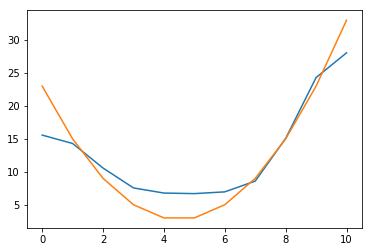

In [567]:
X,y = get_quadratic_data(-5,6)
nn.fit(X,y)
predictions = nn.predict(X)
plt.plot(predictions)
plt.plot(y)
plt.show()